In [4]:
import json
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from PIL import Image
import scipy.misc
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms


from src import preprocess_util
from src import patientutils

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
data_dir = '/workdir/hassony/data'
train_dir = data_dir + '/Training'
save_dir = data_dir + '/storage'

train_df = pd.read_csv('/workdir/hassony/data/Training.csv')

In [44]:
def get_tumor_rec(df, patient_id):
    """
    Returns the target value for the patient 
    (1 or 0 coding for tumor recurrence)
    """
    return int(df[df.Patient_ID==patient_id].Local_tumor_recurrence)


In [163]:
patch_size = 25
patient_patches = preprocess_util.extract_all_patches(train_dir, patch_size)

In [21]:
train_df

,Patient_ID,HPV/p16_status,Gender,Age_at_diagnosis,Race,Tumor_side,Tumor_subsite,T_category,N_category,AJCC_Stage,Pathological_grade,Smoking_status_at_diagnosis,Smoking_Pack-Years
0,1,1,Male,58,White,L,Tonsil,2,0,II,III,Former,5.0
1,2,0,Female,78,White,R,BOT,3,0,III,II,Former,70.0
2,3,1,Male,57,White,R,Tonsil,1,2b,IV,III,Current,30.0
3,4,1,Female,56,White,R,BOT,2,2b,IV,III,Never,0.0
4,5,1,Female,60,White,L,Tonsil,2,2b,IV,II,Never,0.0
5,6,1,Male,66,White,R,BOT,1,1,III,III,Never,0.0
6,7,1,Female,72,White,L,BOT,4,0,IV,II,Former,26.0
7,9,0,Female,71,White,L,Tonsil,1,2a,IV,I,Former,50.0
8,11,1,Male,50,White,L,BOT,3,2b,IV,III,Current,30.0
9,12,1,Male,54,White,R,BOT,2,2c,IV,II,Former,60.0


In [46]:
pkl.dump(patient_patches, open(save_dir +
                                '/train_patient_patches_size{size}.pkl'.format(size=),
                                'wb'))
patient_patches = pkl.load( open(save_dir + '/train_patient_patches_size{size}.pkl'.format(size=), 'rb'))

In [165]:
pos_patients = patientutils.get_patients_by_rec(train_df, patient_patches.keys(), patient_patches, 1)
neg_patients = patientutils.get_patients_by_rec(train_df, patient_patches.keys(), patient_patches, 0)

def make_train_test_lists(pos_patients, neg_patients):
    # If needed make the number of patients even
    print(len(pos_patients))
    print(len(neg_patients))
    if(len(pos_patients) % 2 != 0):
        pos_patients = pos_patients[:-1]
    if(len(neg_patients) % 2 != 0):
        neg_patients = neg_patients[:-1]
    split_pos = np.split(np.random.permutation(pos_patients), 2)
    split_neg = np.split(np.random.permutation(neg_patients), 2)

    training_set = list(split_pos[0]) + list(split_neg[0])
    test_set = list(split_pos[1]) + list(split_neg[1])
    return training_set, test_set
    
train_list, test_list = make_train_test_lists(pos_patients, neg_patients)

53
18


In [166]:
print('{0} negative hpv patients'.format(len(neg_patients)))
print('{0} positive hpv patients'.format(len(pos_patients)))

18 negative hpv patients
53 positive hpv patients


In [167]:
def list_to_tensor(tensor_list):
    """
    Turns a list of tensors into one big tensor
    list's tensors are concatenated on the first dimension
    """
    tensor_nb = len(tensor_list)
    tensor_shape = tensor_list[0].numpy().shape
    tensor = torch.Tensor(np.zeros([tensor_nb, 1] + list(tensor_shape)))
    for idx in range(len(tensor_list)):
        tensor[idx, 0,] = tensor_list[idx]
    return tensor

def create_patch_target(patient_list, patient_patches, patient_df):
    """
    Get all patches as list of tensors and targets as list
    @patient_list contains the list of patients
    @patient_patches is the dictionnary with all patients id as key and patches as values
    @patient_df is the dataframe that contains all patient's info
    """
    all_patches = []
    all_targets = []
    for patient in patient_list:
        patches = torch.Tensor(patient_patches[patient])
        tumor_rec = patientutils.get_hpv_status(patient_df, patient)
        if(len(patches)):
            nb_patch = patches.numpy().shape[0]
            for idx_patch in range(nb_patch):
                all_patches.append(patches[idx_patch,:,:])
                all_targets.append(tumor_rec)
    return all_patches, all_targets           

In [168]:
train_patches, train_targets = create_patch_target(train_list, patient_patches, train_df)
test_patches, test_targets = create_patch_target(test_list, patient_patches, train_df)


In [169]:
print('Extracted {patch_nb} patches for training'.format(patch_nb=len(train_patches)))
print('Extracted {patch_nb} patches for testing'.format(patch_nb=len(test_patches)))

Extracted 428408 patches for training
Extracted 309129 patches for testing


In [170]:
def get_mean_patch(train_patches):
    train_patches_tensor = list_to_tensor(train_patches)
    mean_patch = torch.mean(train_patches_tensor, 0)
    return mean_patch[0,0,:,:]

mean_patch = get_mean_patch(train_patches)

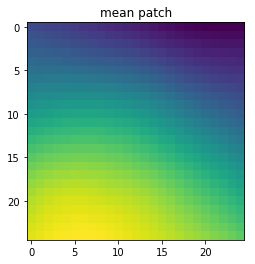

In [171]:
plt.imshow(mean_patch.numpy())
plt.title('mean patch')
plt.show()

In [172]:
def get_indexes_to_remove(targets, disp=False):
    """
    Returns the list of indexes of patches to remove to obtain a balanced data set
    """
    all_pos_indexes = np.where(np.asarray(targets) == 1)[0]
    print('{pos_nb} positive patches'.format(pos_nb=len(all_pos_indexes)))
    all_neg_indexes = np.where(np.asarray(targets) == 0)[0]
    print('{neg_nb} negative patches'.format(neg_nb=len(all_neg_indexes)))
    indexes_to_remove = np.random.choice(all_neg_indexes, len(all_neg_indexes) - len(all_pos_indexes), replace=False)
    return indexes_to_remove



In [173]:
def create_balanced_tensors(train_targets, train_patches):
    train_targets = train_targets[:]
    train_patches = train_patches[:]
    indexes_to_remove = get_indexes_to_remove(train_targets)
    train_targets = np.delete(train_targets, indexes_to_remove)
    train_patches = np.delete(train_patches, indexes_to_remove)
    train_targets = [torch.Tensor([int(tumor_rec), 1 - int(tumor_rec)]) for tumor_rec in train_targets]
    train_targets = list_to_tensor(train_targets)
    train_patches = list_to_tensor(train_patches)
    return train_targets, train_patches

In [174]:
train_target_tensors, train_patch_tensors = create_balanced_tensors(train_targets, train_patches)
test_target_tensors, test_patch_tensors = create_balanced_tensors(test_targets, test_patches)


210644 positive patches
217764 negative patches
165892 positive patches
143237 negative patches


In [175]:
print(train_patch_tensors.size())
print(test_patch_tensors.size())

torch.Size([421288, 1, 25, 25])
torch.Size([188547, 1, 25, 25])


In [176]:
batch_size = 10
train_dataset = torch.utils.data.TensorDataset(train_patch_tensors, train_target_tensors)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(test_patch_tensors, test_target_tensors)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
print(len(train_loader), 'training samples')
print(len(test_loader), 'training samples')

42129 training samples
18855 training samples


In [192]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        # self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x , 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.conv3(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 64)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [193]:
def get_metrics(target, prediction):
    # assert(len(target) == len(prediction), 'target and prediction lists should be of same length')
    sample_nb = len(target)
    confusion_mat = np.zeros([2,2])
    true_positives = sum(1 for tar, pred in zip(target, prediction) if (tar and pred)) 
    true_negatives = sum(1 for tar, pred in zip(target, prediction) if (not tar and not pred)) 
    false_positives = sum(1 for tar, pred in zip(target, prediction) if (not tar and pred)) 
    false_negatives = sum(1 for tar, pred in zip(target, prediction) if (tar and not pred))
    confusion_mat[1, 1] = true_positives
    confusion_mat[0, 0] = true_negatives
    confusion_mat[1, 0] = false_positives
    confusion_mat[0, 1] = false_negatives
    accuracy = (true_positives + true_negatives)/sample_nb
    return confusion_mat, accuracy



In [194]:
def train_net(dataloader, net, loss_criterion, mean_patch, optimizer, learn=True):
    running_loss = 0.0
    prediction = []
    target = []
    for i, data_item in enumerate(dataloader, 0):
        if (i<400):
            # get the inputs
            inputs, labels = data_item

            # Remove mean patch from current patch
            inputs = inputs - mean_patch.repeat(inputs.size()[0], 1, 1, 1)
            labels = labels.squeeze()
            
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            for label in labels:
                if(label.data[0]==1):
                    target.append(1)
                else:
                    target.append(0)
                
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = net(inputs)
            loss = loss_criterion(outputs, labels)

            # if learning  backward + optimize
            if (learn):
                loss.backward()        
                optimizer.step()

            running_loss += loss.data[0]
            
            
            for output in outputs:
                if(output.data[0]>0.5):
                    prediction.append(1)
                else:
                    prediction.append(0)
            
            # If network currently learning

    return prediction, target, running_loss


In [195]:
def simulation(dataloader, test_dataloader, net, loss_criterion, mean_patch, epochNb, learning_rate):
    
    # Initialize performance arrays
    train_losses = np.zeros(epochNb)
    train_accuracies = np.zeros(epochNb)
    test_losses = np.zeros(epochNb)
    test_accuracies = np.zeros(epochNb)

    train_learning = False
    optimizer = torch.optim.Adam(net.parameters(), learning_rate)
    for epoch in range(epochNb): # loop over the dataset multiple times
        if (epoch>0):
            train_learning = True

        # train
        prediction, target, train_loss = train_net(dataloader, net, loss_criterion, mean_patch,
                                                   optimizer, learn=train_learning)
        train_conf_mat, train_acc = get_metrics(target, prediction)
        train_losses[epoch] = train_loss

        # Save results
        train_accuracies[epoch] = train_acc
        train_losses[epoch] = train_loss
        
        # print epoch train results
        print('Training loss: {los}'.format(los=train_loss))
        print('Training confusion matrix')
        print(train_conf_mat)
        print('Training accuracy : ', train_acc) 

        # test
        test_prediction, test_target, test_loss = train_net(test_dataloader, net, loss_criterion, mean_patch,
                                                            optimizer, learn=False)
        test_conf_mat, test_acc = get_metrics(test_target, test_prediction)
        test_losses[epoch] = test_loss

        # Save results
        test_accuracies[epoch] = test_acc
        test_losses[epoch] = test_loss
        
        # print epoch train results
        print('Testing loss: {los}'.format(los=test_loss))
        print('Testing confusion matrix')
        print(test_conf_mat)
        print('Testing accuracy : ', test_acc) 
        
    return train_losses, test_losses, train_accuracies, test_accuracies

In [199]:
model = Net()

bce_criterion = nn.BCELoss()
epoch = 100
learning_rate = 0.000001
momentum = 0.9
train_losses, test_losses, train_accuracies, test_accuracies = simulation( test_loader, train_loader, model, bce_criterion, mean_patch, epoch, learning_rate)

Training loss: 160.07225636392832
Training confusion matrix
[[   45.    72.]
 [  450.  3433.]]
Training accuracy :  0.8695
Testing loss: 865.2105834186077
Testing confusion matrix
[[   86.    59.]
 [ 1864.  1991.]]
Testing accuracy :  0.51925
Training loss: 164.72896196320653
Training confusion matrix
[[   33.    45.]
 [  475.  3447.]]
Training accuracy :  0.87
Testing loss: 905.0134058594704
Testing confusion matrix
[[   80.    44.]
 [ 1821.  2055.]]
Testing accuracy :  0.53375
Training loss: 154.41140967048705
Training confusion matrix
[[   36.    43.]
 [  444.  3477.]]
Training accuracy :  0.87825
Testing loss: 971.3795136213303
Testing confusion matrix
[[   84.    26.]
 [ 1925.  1965.]]
Testing accuracy :  0.51225
Training loss: 160.24519263207912
Training confusion matrix
[[   45.    37.]
 [  443.  3475.]]
Training accuracy :  0.88
Testing loss: 930.9928900301456
Testing confusion matrix
[[  101.    26.]
 [ 1948.  1925.]]
Testing accuracy :  0.5065
Training loss: 170.3477571457624

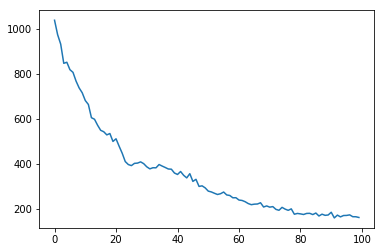

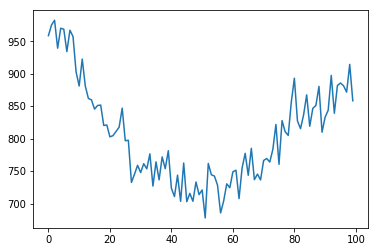

In [197]:
plt.plot(train_losses)
plt.show()
plt.plot(test_losses)
plt.show()

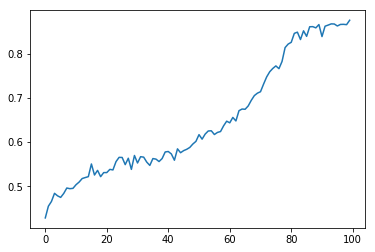

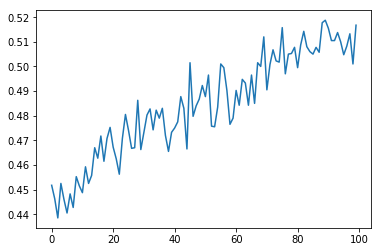

In [198]:
plt.plot(train_accuracies)
plt.show()
plt.plot(test_accuracies)
plt.show()

In [556]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
prediction_, target_, loss_ = train_net(test_loader, model, bce_criterion, mean_patch,  optimizer, learn=False)
get_metrics(target_, prediction_)

(array([[  955.,  1297.],
        [ 1049.,   699.]]), 0.4135)